# Golden Moves: Forecasting Gold Price Trends with Stacking ML

# Project Overview

Gold is considered a safe-haven asset, making its price prediction crucial for investors, analysts, and financial strategists. This project aims to build a robust multi-class classification model that predicts the next-day price movement of gold (GLD) — whether it will rise, fall, or remain stable.

Using a combination of technical indicators, feature selection, class balancing techniques, and a powerful stacking ensemble classifier, we aim to achieve a high level of predictive performance.

# Install Required Library Versions

To ensure compatibility between `scikit-learn` and `imbalanced-learn`, we install specific versions known to work well together.

In [1]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0


# Importing Required Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, accuracy_score, cohen_kappa_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
import lightgbm as lgb
!pip install catboost
import catboost as cb
from imblearn.combine import SMOTEENN
!pip install optuna
import optuna
import warnings
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.3 MB/s eta 0:00:00


# Load Dataset and Inspect
We load the dataset and convert the `Date` column to datetime format.  
Initial inspection includes general info, descriptive statistics, and plotting trends and correlations.


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB
None

=== Dataset Description ===
                                Date          SPX          GLD          USO  \
count                           2290  2290.000000  2290.000000  2290.000000   
mean   2013-03-17 08:23:41.135371008  1654.315776   122.732875    31.842221   
min              2008-01-02 00:00:00   676.530029    70.000000     7.960000   
25%              2010-08-20 00:00:00  1239.874969   109.725000    14.380000   
50%              2013-

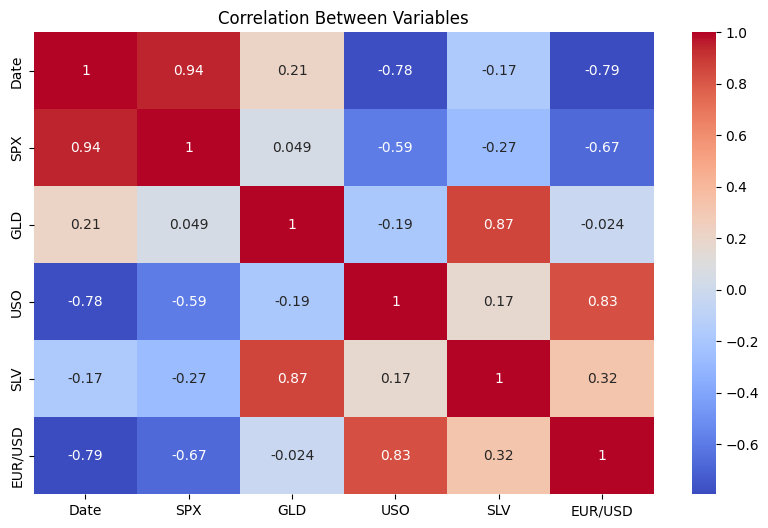

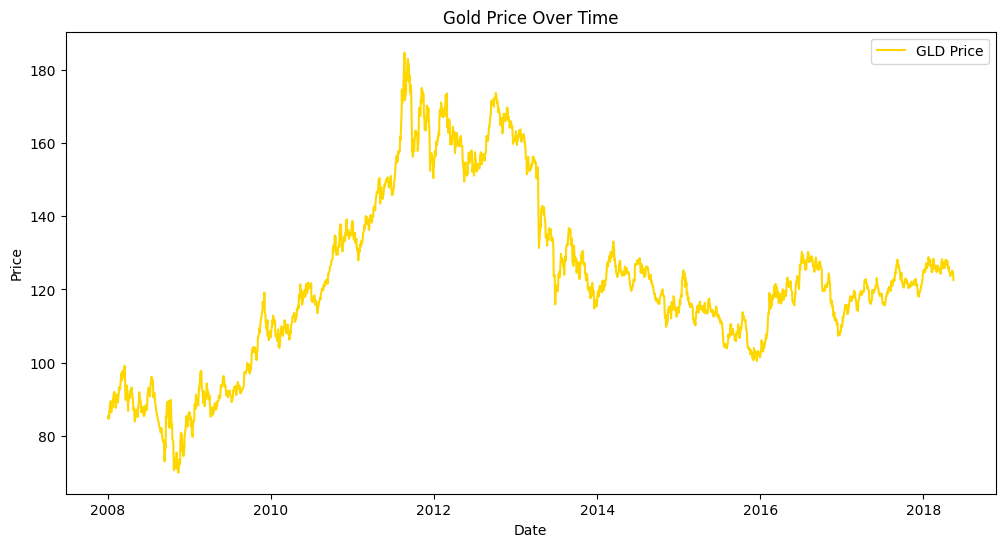

In [5]:
data = pd.read_csv('/content/gld_price_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Data Overview
print("\n=== Dataset Info ===")
print(data.info())
print("\n=== Dataset Description ===")
print(data.describe())

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Variables")
plt.show()

# GLD Price Over Time
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['GLD'], label='GLD Price', color='gold')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Feature Engineering
To enhance the predictive power of our model, we created several new features based on domain knowledge from financial time series analysis. Below is a brief description of each engineered feature:

- **`Price_Change`**: The percentage change in the gold price between today and the next day. It serves as the basis for classification into three categories: Up, Down, or Stable.

- **`GLD_lag1` & `GLD_lag2`**: Lag features representing the price of gold 1 and 2 days ago. These help capture momentum or recent trends.

- **`GLD_MA3` & `GLD_MA7`**: 3-day and 7-day moving averages of gold prices, respectively. These smooth out short-term fluctuations and help identify local trends.

- **`GLD_LogRet`**: Logarithmic return of gold price, calculated as `log(GLD_t / GLD_{t-1})`. This is a normalized measure of daily return that’s more stable and additive over time.

- **`GLD_Volatility`**: Rolling standard deviation of the gold price over a 5-day window, used to quantify recent market uncertainty and fluctuations.

- **`RSI` (Relative Strength Index)**: A momentum oscillator measuring the speed and change of price movements over a 14-day window. Values above 70 indicate overbought conditions, while values below 30 suggest oversold conditions.

- **`MACD` (Moving Average Convergence Divergence)**: The difference between two exponential moving averages (EMA 12 and EMA 26), highlighting bullish or bearish momentum.

- **`MACD_signal`**: A 9-day EMA of the MACD line, used as a trigger for buy/sell signals in technical analysis.

- **`Bollinger_upper` & `Bollinger_lower`**: Upper and lower bands calculated as ±2 standard deviations from a 20-day moving average. These bands represent the volatility envelope of the gold price and are useful for detecting breakouts or mean reversions.

These features enrich the dataset and provide the model with historical context, trend detection, and volatility awareness—all crucial for financial time series forecasting.

We also calculate the **target** as a 3-class label:
- `0` = Down (< -1%)
- `1` = Stable (between -1% and +1%)
- `2` = Up (> +1%)

In [6]:
# Create Target Variable: Percentage change

data['Price_Change'] = (data['GLD'].shift(-1) - data['GLD']) / data['GLD'] * 100

# Create Technical Indicators
data['GLD_lag1'] = data['GLD'].shift(1)
data['GLD_lag2'] = data['GLD'].shift(2)
data['GLD_MA3'] = data['GLD'].rolling(window=3).mean()
data['GLD_MA7'] = data['GLD'].rolling(window=7).mean()
data['GLD_LogRet'] = np.log(data['GLD'] / data['GLD'].shift(1))
data['GLD_Volatility'] = data['GLD'].rolling(window=5).std()

# RSI
change = data['GLD'].diff()
gain = change.clip(lower=0)
loss = -change.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema12 = data['GLD'].ewm(span=12).mean()
ema26 = data['GLD'].ewm(span=26).mean()
data['MACD'] = ema12 - ema26
data['MACD_signal'] = data['MACD'].ewm(span=9).mean()

# Bollinger Bands
rolling_mean = data['GLD'].rolling(window=20).mean()
rolling_std = data['GLD'].rolling(window=20).std()
data['Bollinger_upper'] = rolling_mean + (2 * rolling_std)
data['Bollinger_lower'] = rolling_mean - (2 * rolling_std)

# Remove NaNs and create classes
data.dropna(inplace=True)
def classify_change(x):
    if x > 1:
        return 2
    elif x < -1:
        return 0
    else:
        return 1
data['Target'] = data['Price_Change'].apply(classify_change)

# Data Preprocessing
In this section, we prepare the dataset for modeling. Key steps include:

- **Feature selection**: Selecting both market data and technical indicators.
- **Standardization**: Features are standardized using `StandardScaler` to ensure optimal model convergence.
- **Class balancing**: We use `SMOTEENN` to both oversample minority classes and clean noisy examples — improving classifier robustness.
- **Train/Test Split**: The dataset is split into training and test sets with stratified sampling to maintain class distribution.

In [7]:
features = ['SPX', 'USO', 'SLV', 'EUR/USD',
            'GLD_lag1', 'GLD_lag2', 'GLD_MA3', 'GLD_MA7',
            'GLD_LogRet', 'GLD_Volatility', 'RSI', 'MACD',
            'MACD_signal', 'Bollinger_upper', 'Bollinger_lower']

X = data[features]
y = data['Target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTEENN to balance the dataset
X_res, y_res = SMOTEENN(random_state=42).fit_resample(X_scaled, y)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Feature Selection
Here we select the most important features using an `ExtraTreesClassifier`:

- It is an ensemble method that ranks features based on how much they reduce impurity.
- We use `SelectFromModel` with a threshold to retain only features with above-average importance.
- This step helps reduce overfitting and accelerates training.

In [8]:
selector = ExtraTreesClassifier(n_estimators=100, random_state=42)
selector.fit(X_train, y_train)
sfm = SelectFromModel(selector, prefit=True, threshold='mean')
X_train_sel = sfm.transform(X_train)
X_test_sel = sfm.transform(X_test)


# Hyperparameter Tuning with Optuna (XGBoost)
We use **Optuna**, an efficient hyperparameter optimization library, to tune the XGBoost classifier.

- The objective function maximizes the **weighted F1 score**, a good choice for imbalanced multiclass problems.
- Parameters like `n_estimators`, `max_depth`, `learning_rate`, and regularization terms are explored.
- After optimization, we retrain XGBoost with the best parameters.

In [9]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }
    model = XGBClassifier(**params)
    model.fit(X_train_sel, y_train)
    preds = model.predict(X_test_sel)
    return f1_score(y_test, preds, average='weighted')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Train final XGB
best_params = study.best_params
best_params.update({'use_label_encoder': False, 'eval_metric': 'mlogloss'})
xgb_final = XGBClassifier(**best_params)
xgb_final.fit(X_train_sel, y_train)

[I 2025-07-13 18:32:50,343] A new study created in memory with name: no-name-5d4cfeeb-e1f5-4ef0-941c-8ee4a4c53edb
[I 2025-07-13 18:32:55,773] Trial 0 finished with value: 0.6729781354460096 and parameters: {'n_estimators': 187, 'max_depth': 8, 'learning_rate': 0.039310651795260575, 'subsample': 0.641482538102789, 'colsample_bytree': 0.8809717312774162, 'gamma': 4.9881547324862545, 'reg_alpha': 0.2510957591735141, 'reg_lambda': 3.884440957068122}. Best is trial 0 with value: 0.6729781354460096.
[I 2025-07-13 18:32:56,153] Trial 1 finished with value: 0.7282305848494669 and parameters: {'n_estimators': 164, 'max_depth': 8, 'learning_rate': 0.03627150010108733, 'subsample': 0.766532335907693, 'colsample_bytree': 0.7598177279546708, 'gamma': 2.5968067188688835, 'reg_alpha': 3.0817696727213075, 'reg_lambda': 3.0512843336869233}. Best is trial 1 with value: 0.7282305848494669.
[I 2025-07-13 18:32:56,328] Trial 2 finished with value: 0.6485779518741843 and parameters: {'n_estimators': 215, 'm

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.796402000897933, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.0349056344536056, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15371036984564873,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=131, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Stacking Classifier
We use a stacking ensemble to combine multiple classifiers:

- **Base Learners**: XGBoost, LightGBM, CatBoost.
- **Meta Learner**: Logistic Regression.

Stacking allows the model to learn from the strengths of each base learner, improving generalization and predictive performance.

In [10]:
lgb_model = lgb.LGBMClassifier(random_state=42)
cat_model = cb.CatBoostClassifier(verbose=0, random_state=42)

stacking = StackingClassifier(
    estimators=[
        ('xgb', xgb_final),
        ('lgb', lgb_model),
        ('cat', cat_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

stacking.fit(X_train_sel, y_train)
y_pred = stacking.predict(X_test_sel)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 2108, number of used features: 8
[LightGBM] [Info] Start training from score -0.904735
[LightGBM] [Info] Start training from score -1.664533
[LightGBM] [Info] Start training from score -0.901225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1686, number of used features: 8
[LightGBM] [Info] Start training from score -0.905084
[LightGBM] [Info] Start training from score -1.664923
[LightGBM] [Info] Start training from score -0.900695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds

# Evaluation Metrics
We evaluate model performance using several metrics:

- **Accuracy**: Overall correctness of predictions.
- **Weighted F1 Score**: Balances precision and recall, accounting for class imbalance.
- **Precision**: Focuses on relevance of positive predictions.
- **Cohen's Kappa**: Measures agreement beyond random chance.
- **Classification Report**: Detailed per-class metrics.

=== Final Results ===
Accuracy: 0.9240986717267552
F1 Score (weighted): 0.9233456392220789
Precision (weighted): 0.9257142207302718
Cohen's Kappa: 0.8793712196210608

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       213
           1       0.96      0.81      0.88       100
           2       0.93      0.95      0.94       214

    accuracy                           0.92       527
   macro avg       0.93      0.90      0.92       527
weighted avg       0.93      0.92      0.92       527



<Figure size 600x400 with 0 Axes>

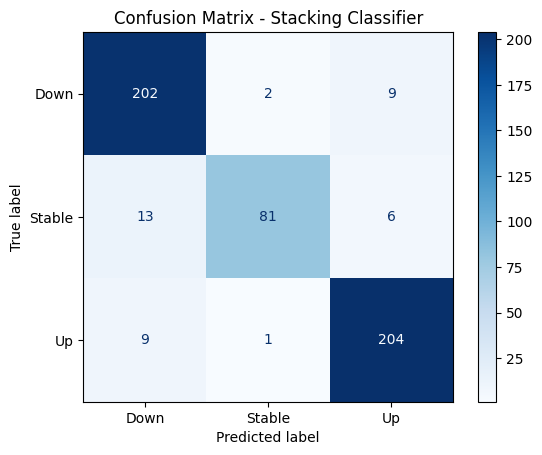

In [11]:
print("=== Final Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Stable', 'Up'])
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Stacking Classifier")
plt.grid(False)
plt.show()

# Plotting: True vs Predicted Classes
To better understand the model's behavior, we plot a comparison between the actual target values and the predicted values.

This helps identify:

Where the model tends to make errors.

Whether the model is biased towards certain classes.

If predictions follow the real trend (Up, Stable, Down).

We limit the plot to the first 100 test samples for readability.

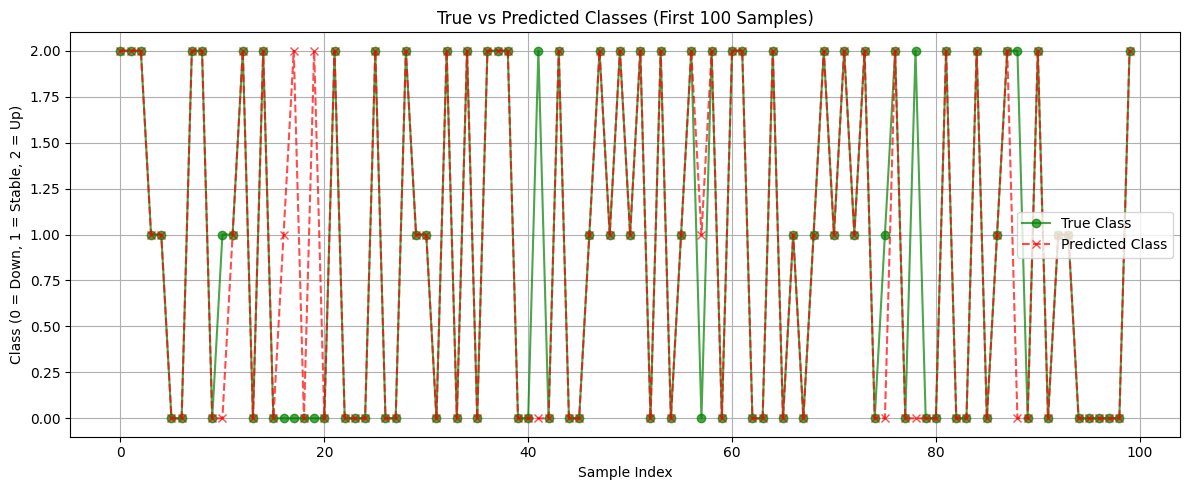

In [12]:
def plot_true_vs_predicted(y_true, y_pred, sample_size=100):

    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample_size], label='True Class', marker='o', linestyle='-', color='green', alpha=0.7)
    plt.plot(y_pred[:sample_size], label='Predicted Class', marker='x', linestyle='--', color='red', alpha=0.7)
    plt.title("True vs Predicted Classes (First {} Samples)".format(sample_size))
    plt.xlabel("Sample Index")
    plt.ylabel("Class (0 = Down, 1 = Stable, 2 = Up)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_true_vs_predicted(y_test.values, y_pred, sample_size=100)


# Inference on New Data
We test the trained stacking model on a new, hypothetical example. The same transformations (scaling + feature selection) are applied before prediction.

The output is a class label:
- `0`: Price will go **Down**
- `1`: Price will stay **Stable**
- `2`: Price will go **Up**

This simulation shows how the pipeline can be used in real-time forecasting scenarios.

In [13]:
example_input = pd.DataFrame([{
    'SPX': 4200,
    'USO': 75,
    'SLV': 24,
    'EUR/USD': 1.10,
    'GLD_lag1': 185,
    'GLD_lag2': 184,
    'GLD_MA3': 184.5,
    'GLD_MA7': 183.9,
    'GLD_LogRet': 0.001,
    'GLD_Volatility': 0.8,
    'RSI': 55,
    'MACD': 0.2,
    'MACD_signal': 0.15,
    'Bollinger_upper': 188,
    'Bollinger_lower': 179
}])

example_input_scaled = scaler.transform(example_input)
example_input_sel = sfm.transform(example_input_scaled)
predicted_class = stacking.predict(example_input_sel)
print(f"\nPrediction for new input: {predicted_class[0]} (0: Down, 1: Stable, 2: Up)")




Prediction for new input: 1 (0: Down, 1: Stable, 2: Up)


#  Final Conclusion
This notebook presented a comprehensive end-to-end pipeline for predicting gold price movement using machine learning techniques. Here's a recap of the key steps:

🔹 We started by analyzing the financial time series data and engineering powerful technical indicators such as RSI, MACD, Bollinger Bands, and volatility.

🔹 The target variable was designed as a 3-class classification problem:
- `0` for a significant drop,
- `1` for a stable price, and
- `2` for a significant rise.

🔹 Advanced data preprocessing techniques were applied, including:
- Feature scaling,
- Handling class imbalance using **SMOTEENN**,
- And **feature selection** with ExtraTreesClassifier.

🔹 We optimized an **XGBoost model** using **Optuna**, and further enhanced performance by building a **stacked ensemble** combining XGBoost, LightGBM, and CatBoost, with Logistic Regression as a meta-learner.

🔹 The final ensemble model achieved strong performance, with good **accuracy**, **F1-score**, and **Cohen’s Kappa**, indicating reliable classification across all three classes.

🔹 Additionally, the **confusion matrix** helped us visualize misclassifications and better understand where improvements could be made.

# Final Note
Although this project was initially designed as a regression problem, I took the challenge of reformulating it as a classification task.
My goal was to push the boundaries and build a meaningful, high-performing model capable of predicting gold price movement direction (Down, Stable, Up).
This shift allowed for a more actionable and strategic interpretation of the results — especially in financial decision-making scenarios.